In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 125
import seaborn as sns
from Bio import SeqIO, Seq
import scipy.stats as st
import timeit

import glob, os, yaml, subprocess, itertools, sparse, vcf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from statsmodels.distributions.empirical_distribution import ECDF

who_variants = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/MIC_data/WHO_resistance_variants_all.csv")
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
def compare_models_population_structure_correction(res_df, res_df_noPopCorr, alpha=0.05, diff_thresh=0, return_diff=False):
    '''
    Comparison to determine if population structure determination is necessary. Things to compare:
    
    1. Do all the same variants have non-zero coefficients (the returned dataframes are only non-zero coefficients)?
    2. Compute Pearson correlation between coefficients.
    3. Do features have p-values that are on the same side of the threshold (0.05 or 0.01)?
    '''
    
    # merge outer to include anything (in case some features have 0 or non-zero coefficients, depending on whether PCs are included)
    plot_df = res_df[["orig_variant", "coef", "pval", "coef_LB", "coef_UB"]].merge(res_df_noPopCorr[["orig_variant", "coef", "pval", "coef_LB", "coef_UB"]], how="outer", on="orig_variant")    
    
    # then drop the principal components
    plot_df = plot_df.loc[~plot_df["orig_variant"].str.contains("PC")]
    
    plot_df_missing = plot_df.loc[(pd.isnull(plot_df["coef_x"])) | (pd.isnull(plot_df["coef_y"]))]
    print(f"{len(plot_df_missing)} coefficients are zero in one model and non-zero in the other")
    
    # NaNs are 0 coefficients, fill them in for plotting and correlation computations
    plot_df[["coef_x", "coef_y"]] = plot_df[["coef_x", "coef_y"]].fillna(0)
    
    # coefficient without population structure correction - coefficient with correction
    plot_df["diff"] = plot_df["coef_y"] - plot_df["coef_x"]
    plot_df["percent_diff"] = plot_df["diff"] / plot_df["coef_x"] * 100

    fig, ax = plt.subplots(1, 2, figsize=(9, 3))
    sns.scatterplot(data=plot_df, x="coef_x", y="coef_y", ax=ax[0], alpha=0.5)
    ax[0].set_xlabel("Coef, Population Structure Correction")
    ax[0].set_ylabel("Coef, No Correction")
    ax[0].set_title(f"Pearson R: {np.round(st.pearsonr(plot_df['coef_x'], plot_df['coef_y'])[0], 4)}")

    sns.scatterplot(data=plot_df, x="coef_x", y="percent_diff", ax=ax[1], alpha=0.5)
    ax[1].set_xlabel("Coef, Population Structure Correction")
    ax[1].set_title("% Difference in Coefs.")

    sns.despine()
    plt.show()
    
    # get features whose coefficients differ by more than some threshold (0 to 100) for percent difference
    # (difference between coefficients without and with correction is greater than the coefficient with population structure correction
    large_diff = plot_df.query("percent_diff >= @diff_thresh | percent_diff <= -@diff_thresh")
    
    # get the number of features with confidence intervals that lie on different sides of 0
    print(f'{len(plot_df.query("coef_LB_x > 0 & coef_UB_x > 0 & coef_LB_y < 0 & coef_UB_y < 0"))} features have confidence intervals on different sides of 0')
    print(f'{len(large_diff.query("coef_LB_x > 0 & coef_UB_x > 0 & coef_LB_y < 0 & coef_UB_y < 0"))} features with very different coefficients have confidence intervals on different sides of 0')
    
    # perform a paired t-test. Sort first for same order
    t_test = st.ttest_rel(res_df.loc[~res_df["orig_variant"].str.contains("PC")].sort_values("orig_variant")["coef"], 
                          res_df_noPopCorr.sort_values("orig_variant")["coef"], alternative="two-sided")
    print(f'\nPaired t-test null: Difference in coefficients is 0 \np-value: {np.round(t_test[1], 4)}')
    
    # TO-DO: COMPARISON OF CONFIDENCE INTERVALS
    
    if return_diff:
        return plot_df.loc[(pd.isnull(plot_df["coef_x"])) | (pd.isnull(plot_df["coef_y"]))]

# Rifampicin

In [5]:
#rif_res = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Drugs/Rifampicin/tiers=1_drop_HET/model_analysis.pkl")
rif_res_noPopCorr = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Rifampicin/tiers=1/phenos=WHO/dropAF_noSyn_noPopCorr/model_analysis.pkl")
rif_res_noPopCorr.shape

# number of principal components with positive coefficients (OR > 1)
#print(len(rif_res.query("coef > 0").loc[rif_res.query("coef > 0").orig_variant.str.contains('PC')]))

# variants in rif_res that are not in the results without population structure correction. Only non-zero coefficients
#print(set(rif_res.orig_variant)-set(rif_res_noPopCorr.orig_variant))

(759, 32)

In [6]:
rif_res_noPopCorr.head(20)

,orig_variant,coef,coef_LB,coef_UB,pval,BH_pval,Bonferroni_pval,genome_index,confidence_WHO_2021,Odds_Ratio,...,PPV_LB,PPV_UB,Sens_LB,Sens_UB,Spec_LB,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB
0,rpoB_p.Ser450Leu,2.7340,2.6951,2.7788,0.0000,0.0000,0.0000,"761154,761155",1) Assoc w R,15.3941,...,0.9842,0.9895,0.6412,0.6587,0.9953,0.9969,138.1291,206.8080,0.3426,0.3604
1,rpoB_p.Asp435Val,0.9368,0.8983,0.9710,0.0000,0.0000,0.0000,761110,1) Assoc w R,2.5518,...,0.9773,0.9954,0.0575,0.0669,0.9994,0.9999,95.6797,472.6733,0.9335,0.9428
2,rpoB_p.His445Tyr,0.7219,0.6887,0.7622,0.0000,0.0000,0.0000,761139,1) Assoc w R,2.0583,...,0.9630,0.9901,0.0363,0.0437,0.9993,0.9998,56.8410,218.5657,0.9567,0.9642
3,rpoB_p.His445Asp,0.6939,0.6603,0.7300,0.0000,0.0000,0.0000,761139,1) Assoc w R,2.0014,...,0.9747,0.9972,0.0313,0.0383,0.9996,1.0000,85.0480,797.6164,0.9619,0.9690
4,rpoB_p.Ser450Phe,0.4809,0.4526,0.5056,0.0000,0.0000,0.0000,"761155,761156",1) Assoc w R,1.6175,...,0.9809,1.0000,0.0132,0.0179,0.9999,1.0000,112.7616,inf,0.9822,0.9868
5,rpoB_p.Ser450Trp,0.4801,0.4439,0.5228,0.0000,0.0000,0.0000,761155,1) Assoc w R,1.6163,...,0.9569,0.9954,0.0152,0.0200,0.9997,1.0000,48.5564,474.7051,0.9802,0.9849
6,rpoB_p.Asp435Tyr,0.3781,0.3528,0.4112,0.0000,0.0000,0.0000,761109,1) Assoc w R,1.4595,...,0.7154,0.8153,0.0175,0.0226,0.9965,0.9979,5.5482,9.7851,0.9797,0.9854
7,rpoB_p.His445Leu,0.3660,0.3374,0.4032,0.0000,0.0000,0.0000,761140,1) Assoc w R,1.4420,...,0.8871,0.9691,0.0105,0.0148,0.9993,0.9998,17.2872,68.8760,0.9856,0.9899
8,rpoB_p.His445Arg,0.3451,0.3099,0.3856,0.0000,0.0000,0.0000,761140,1) Assoc w R,1.4121,...,0.9462,1.0000,0.0074,0.0110,0.9998,1.0000,38.8035,inf,0.9891,0.9927
9,rpoB_p.Leu452Pro,0.3401,0.3133,0.3683,0.0000,0.0000,0.0000,761161,1) Assoc w R,1.4050,...,0.7078,0.8166,0.0139,0.0187,0.9971,0.9983,5.3057,9.8447,0.9835,0.9884


0 coefficients are zero in one model and non-zero in the other


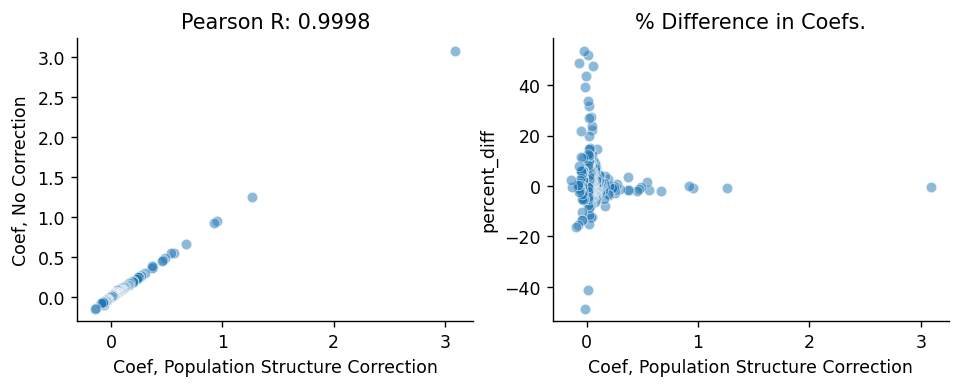

0 features have confidence intervals on different sides of 0
0 features with very different coefficients have confidence intervals on different sides of 0

Paired t-test null: Difference in coefficients is 0 
p-value: 0.7086


In [36]:
compare_models_population_structure_correction(rif_res, rif_res_noPopCorr, alpha=0.05, diff_thresh=0)

In [37]:
#rif_res.query("coef > 0 & pval < 0.05")

In [57]:
#who_variants.loc[(who_variants.drug == 'RIF') & (who_variants.confidence.str.contains("|".join(["1", "2"])))]

# Moxifloxacin

In [4]:
# moxi_res = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Drugs/Moxifloxacin/tiers=1_drop_HET/model_analysis.pkl")

# # number of principal components with positive coefficients (OR > 1)
# print(len(moxi_res.query("coef > 0").loc[moxi_res.query("coef > 0").orig_variant.str.contains('PC')]))

moxi_tier1_WHO_dropAF_noPopCorr = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Moxifloxacin/tiers=1/phenos=WHO/dropAF_noSyn_noPopCorr/model_analysis.pkl")

# variants in moxi_res that are not in the results without population structure correction
#print(set(moxi_res.orig_variant)-set(moxi_res_noPopCorr.orig_variant))

In [7]:
moxi_tier1_WHO_dropAF_noPopCorr.query("coef > 0").head(20)

,orig_variant,coef,coef_LB,coef_UB,pval,BH_pval,Bonferroni_pval,genome_index,confidence_WHO_2021,Odds_Ratio,...,PPV_LB,PPV_UB,Sens_LB,Sens_UB,Spec_LB,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB
0,gyrA_p.Asp94Gly,1.0448,0.9943,1.1000,0.0000,0.0000,0.0000,7582,1) Assoc w R,2.8428,...,0.5219,0.5985,0.3939,0.4632,0.9503,0.9603,8.3784,11.0916,0.5616,0.6351
1,gyrA_p.Ala90Val,0.6109,0.5491,0.6620,0.0000,0.0000,0.0000,7570,1) Assoc w R,1.8420,...,0.3350,0.4300,0.1573,0.2095,0.9551,0.9653,3.8355,5.5914,0.8215,0.8775
2,gyrA_p.Asp94Asn,0.4806,0.4327,0.5269,0.0000,0.0000,0.0000,7581,1) Assoc w R,1.6170,...,0.5859,0.7706,0.0645,0.1023,0.9930,0.9965,10.6175,24.8381,0.9025,0.9407
3,gyrA_p.Asp94Ala,0.4426,0.3900,0.4926,0.0000,0.0000,0.0000,7582,1) Assoc w R,1.5568,...,0.4024,0.5537,0.0762,0.1133,0.9831,0.9888,5.1123,9.3538,0.8983,0.9368
4,gyrA_p.Asp94Tyr,0.3882,0.3444,0.4330,0.0000,0.0000,0.0000,7581,1) Assoc w R,1.4744,...,0.5970,0.8305,0.0360,0.0664,0.9959,0.9986,11.1325,36.8428,0.9364,0.9664
5,gyrA_p.Ser91Pro,0.3770,0.3268,0.4256,0.0000,0.0000,0.0000,7572,1) Assoc w R,1.4580,...,0.4459,0.6712,0.0384,0.0697,0.9927,0.9962,6.1984,15.3718,0.9355,0.9674
6,gyrA_p.Asp94His,0.2539,0.2117,0.3022,0.0000,0.0000,0.0000,7581,1) Assoc w R,1.2891,...,0.4813,0.8636,0.0111,0.0293,0.9978,0.9995,6.9765,46.4094,0.9721,0.9901
7,gyrB_p.Glu501Asp,0.2449,0.1908,0.2959,0.0000,0.0000,0.0000,6742,1) Assoc w R,1.2774,...,0.6818,0.9643,0.0144,0.0349,0.9987,0.9998,16.4690,202.7628,0.9659,0.9861
8,gyrA_p.Asp89Asn,0.2083,0.1612,0.2588,0.0000,0.0000,0.0000,7566,3) Uncertain significance,1.2316,...,0.6362,1.0000,0.0061,0.0210,0.9992,1.0000,12.6011,inf,0.9793,0.9942
9,gyrA_p.Gly88Cys,0.2012,0.1702,0.2198,0.0000,0.0000,0.0000,7563,1) Assoc w R,1.2228,...,1.0000,1.0000,0.0035,0.0168,1.0000,1.0000,inf,inf,0.9832,0.9965


0 coefficients are zero in one model and non-zero in the other


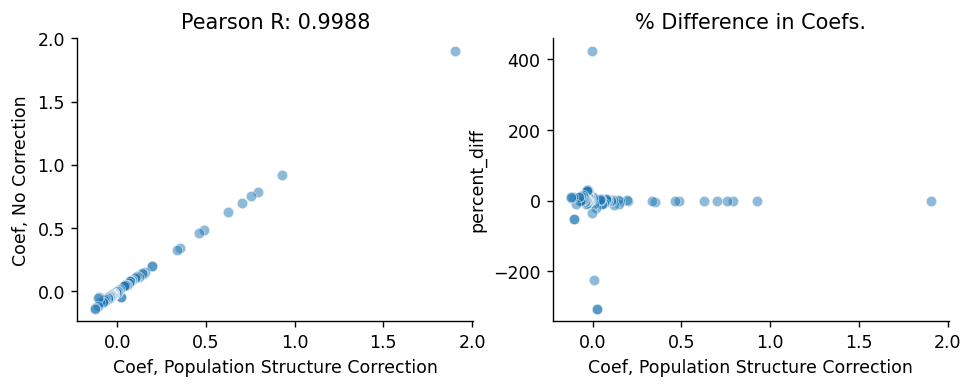

0 features have confidence intervals on different sides of 0
0 features with very different coefficients have confidence intervals on different sides of 0

Paired t-test null: Difference in coefficients is 0 
p-value: 0.0188


In [39]:
compare_models_population_structure_correction(moxi_res, moxi_res_noPopCorr, alpha=0.05, diff_thresh=0)

In [8]:
#moxi_res.query("coef > 0 & pval < 0.05")[["orig_variant", "OR_Lower_CI", "Odds_Ratio", "OR_Upper_CI", "PPV_Lower_CI", "PPV", "PPV_Upper_CI", "pval", "BH_pval", "Bonferroni_pval", "confidence_WHO_2021"]]

In [9]:
#who_variants.loc[(who_variants.drug == 'MXF') & (who_variants.confidence.str.contains("|".join(["1", "2"])))]

# Pyrazinamide

In [40]:
pza_res = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Drugs/Pyrazinamide/tiers=1_drop_HET/model_analysis.pkl")

# number of principal components with positive coefficients (OR > 1)
print(len(pza_res.query("coef > 0").loc[pza_res.query("coef > 0").orig_variant.str.contains('PC')]))

pza_res_noPopCorr = pd.read_pickle("/n/data1/hms/dbmi/farhat/ye12/who/analysis/Drugs/Pyrazinamide/tiers=1_drop_HET_noPopCorr/model_analysis.pkl")

4


In [43]:
moxi_res

,orig_variant,coef,coef_LB,coef_UB,pval,BH_pval,Bonferroni_pval,genome_index,confidence_WHO_2021,Odds_Ratio,...,PPV_LB,PPV_UB,Sens_LB,Sens_UB,Spec_LB,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB
0,gyrA_p.Asp94Gly,1.9061,1.7676,2.0712,0.0000,0.0000,0.0000,7582,1) Assoc w R,6.7267,...,0.9190,0.9766,0.3916,0.4759,0.9883,0.9967,37.2177,134.0078,0.5277,0.6127
1,gyrA_p.Ala90Val,0.9271,0.8179,1.0400,0.0000,0.0000,0.0000,7570,1) Assoc w R,2.5273,...,0.5033,0.6596,0.1392,0.2058,0.9514,0.9699,3.2431,6.0122,0.8256,0.8980
2,gyrA_p.Asp94Asn,0.7912,0.6748,0.9433,0.0000,0.0000,0.0000,7581,1) Assoc w R,2.2062,...,0.8500,1.0000,0.0473,0.0907,0.9967,1.0000,18.0950,inf,0.9104,0.9544
3,gyrA_p.Asp94Ala,0.7553,0.6559,0.8654,0.0000,0.0000,0.0000,7582,1) Assoc w R,2.1283,...,0.6111,0.8310,0.0771,0.1296,0.9818,0.9928,4.9486,15.2090,0.8799,0.9358
4,gyrA_p.Asp94Tyr,0.7015,0.6042,0.8169,0.0000,0.0000,0.0000,7581,1) Assoc w R,2.0168,...,0.8750,1.0000,0.0340,0.0744,0.9980,1.0000,22.3362,inf,0.9262,0.9665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,gyrA_p.Gln613Glu,-0.1095,-0.1400,-0.0787,0.0000,0.0000,0.0000,9138,3) Uncertain significance,0.8962,...,0.0000,0.0000,0.0000,0.0000,0.9854,0.9948,0.0000,0.0000,1.0052,1.0148
134,gyrA_p.Asp641Glu,-0.1229,-0.1518,0.0000,0.0258,0.8920,1.0000,9224,3) Uncertain significance,0.8843,...,0.0000,0.0000,0.0000,0.0000,0.9980,1.0000,0.0000,0.0000,1.0000,1.0020
135,gyrA_p.Leu346Val,-0.1242,-0.1559,0.0000,0.0035,0.2244,1.0000,8337,3) Uncertain significance,0.8832,...,0.0000,0.0000,0.0000,0.0000,0.9967,1.0000,0.0000,0.0000,1.0000,1.0033
136,PC4,-0.1421,-0.2595,0.0056,0.0198,0.7223,1.0000,NaN,NaN,0.8676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
pza_res_noPopCorr

,orig_variant,coef,coef_LB,coef_UB,pval,BH_pval,Bonferroni_pval,genome_index,confidence_WHO_2021,Odds_Ratio,...,PPV_LB,PPV_UB,Sens_LB,Sens_UB,Spec_LB,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB
0,pncA_p.His57Asp,0.5579,0.5239,0.5891,0.0000,0.0000,0.0000,2289073,1) Assoc w R,1.7470,...,0.9673,1.0000,0.0485,0.0653,0.9997,1.0000,157.1213,inf,0.9347,0.9516
1,pncA_c.-11A>G,0.4056,0.3679,0.4493,0.0000,0.0000,0.0000,2289252,1) Assoc w R,1.5002,...,0.8991,0.9818,0.0293,0.0432,0.9993,0.9999,47.2913,285.4402,0.9572,0.9711
2,pncA_p.Gln10Pro,0.3154,0.2778,0.3629,0.0000,0.0000,0.0000,2289213,1) Assoc w R,1.3708,...,0.8889,1.0000,0.0163,0.0270,0.9995,1.0000,43.0632,inf,0.9732,0.9840
3,pncA_p.Gln141Pro,0.2994,0.2626,0.3465,0.0000,0.0000,0.0000,2288820,1) Assoc w R,1.3491,...,0.8775,1.0000,0.0144,0.0246,0.9995,1.0000,38.5160,inf,0.9756,0.9858
4,pncA_p.His51Asp,0.2992,0.2635,0.3317,0.0000,0.0000,0.0000,2289091,1) Assoc w R,1.3487,...,0.9322,1.0000,0.0125,0.0217,0.9998,1.0000,73.7651,inf,0.9783,0.9875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,pncA_c.-3_-2insC,-0.0496,-0.0619,-0.0360,0.0000,0.0000,0.0000,NaN,NaN,0.9516,...,0.0000,0.3000,0.0000,0.0011,0.9989,0.9997,0.0000,2.2679,0.9995,1.0010
527,pncA_p.Thr87Met,-0.0541,-0.0626,-0.0427,0.0000,0.0000,0.0000,2288982,4) Not assoc w R - Interim,0.9473,...,0.0000,0.0000,0.0000,0.0000,0.9983,0.9994,0.0000,0.0000,1.0006,1.0017
528,panD_c.-26A>G,-0.0587,-0.0678,-0.0456,0.0000,0.0000,0.0000,NaN,NaN,0.9430,...,0.0000,0.0000,0.0000,0.0000,0.9987,0.9997,0.0000,0.0000,1.0003,1.0013
529,clpC1_p.Ile215Val,-0.0630,-0.0968,-0.0215,0.0027,0.0168,1.0000,NaN,NaN,0.9390,...,0.0000,0.3333,0.0000,0.0018,0.9987,0.9996,0.0000,2.6749,0.9989,1.0011


In [41]:
compare_models_population_structure_correction(pza_res, pza_res_noPopCorr, alpha=0.05, diff_thresh=0)

KeyError: "['coef_LB', 'coef_UB'] not in index"

In [56]:
#who_variants.loc[(who_variants.drug == 'PZA') & (who_variants.confidence.str.contains("|".join(["1"])))]